## Clustering by jaccard similarity

with threshold 0.7

reachability

### Data loading

In [ ]:
# import utils.cluster_util as cluster_util
import importlib
importlib.reload(cluster_util)
import utils.cluster_util as cluster_util

In [ ]:
import pandas as pd
import utils.config as config
import utils.util as util

df_err_k = pd.read_excel(config.path_kaggle_error_process.joinpath('nberror_k_eid_p.xlsx'))
df_err_g = pd.read_excel(config.path_github_error_process.joinpath('nberror_g_all_eid_p.xlsx'))

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
df_err_k = df_err_k[df_err_k.is_MLnb&df_err_k.is_relevant&df_err_k.if_ast==1.0]
df_err_g = df_err_g[df_err_g.is_MLnb&df_err_g.is_relevant&df_err_g.if_ast==1.0]
df_err_k = df_err_k.drop_duplicates(subset=['eid'], keep='last')
df_err_g = df_err_g.drop_duplicates(subset=['eid'], keep='last')

### Filter out crashes with null error values

In [4]:
df_err_k_filtered = df_err_k[~df_err_k.evalue.isnull()]
print((df_err_k_filtered.fname.nunique()))
print((df_err_k_filtered.eid.nunique()))

2689
3875


In [5]:
df_err_g_filtered = df_err_g[~df_err_g.evalue.isnull()]
print((df_err_g_filtered.fname.nunique()))
print((df_err_g_filtered.eid.nunique()))

61342
88667


In [17]:
# join the two datasets
df_err_k_filtered.loc[:,"nb_source"] = config.NB_SOURCE["kaggle"]
df_err_g_filtered.loc[:,"nb_source"] = config.NB_SOURCE["github"]
df_err_filtered = pd.concat([df_err_g_filtered, df_err_k_filtered], ignore_index=True, sort=False)
len(df_err_filtered) 

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_16960\1427359510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err_k_filtered.loc[:,"nb_source"] = config.NB_SOURCE["kaggle"]
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_16960\1427359510.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err_g_filtered.loc[:,"nb_source"] = config.NB_SOURCE["github"]


92542

### Preprocess error values

remove specific symbols

In [ ]:
import utils.cluster_util as cluster_util

# for jaccard similarity
df_err_filtered["evalue_processed"] = df_err_filtered.evalue.apply(cluster_util.preprocess_text_similarity)
# for hashing match
# df_err_filtered["evalue_tokenized"] = df_err_filtered.evalue.apply(cluster_util.preprocess_text)
df_err_filtered["hash_evalue_tokenized"] = df_err_filtered.evalue_processed.apply(cluster_util.generateHash)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df_err_processed = df_err_filtered[(~(df_err_filtered.evalue_processed==''))&(~df_err_filtered.evalue_processed.isnull())]
# there is big drop
# because of key errors. key errors tend to be only one word/the key(e.g., 'val_accuracy') in error values? 
# this will be excluded when pregrouping. preprocess_text_similarity() will delete words inside ''
len(df_err_processed)

87922

In [8]:
(df_err_filtered[(df_err_filtered.evalue_processed=='')|df_err_filtered.evalue_processed.isnull()].ename.value_counts())[:10]

ename
keyerror          3911
systemexit         349
valueerror          48
attributeerror      32
assertionerror      28
error               26
typeerror           22
tuneerror           17
overflowerror       15
importerror         10
Name: count, dtype: int64

In [11]:
df_err_filtered[((df_err_filtered.evalue_processed==''))|(df_err_filtered.evalue_processed.isnull())].to_excel(config.path_default.joinpath("df_err_processed_pregroup_null_evalues.xlsx"), index=False, engine='xlsxwriter')

### Clustering - construct similarity matrix

In [9]:
# remove the complete deplicated ones first, otherwise it is too large to cluster/process (too much required memory)
df_err_processed_unique = df_err_processed.drop_duplicates(subset=['hash_evalue_tokenized'], keep='last')
print(df_err_processed.eid.nunique()) #87908
print(df_err_processed_unique.eid.nunique()) #31574
# df_err_processed_unique.to_excel(config.path_default.joinpath("df_err_processed_unique.xlsx"), index=False, engine='xlsxwriter')

87922
10783


In [10]:
from scipy.spatial import distance
from itertools import combinations
import numpy as np

# word level similarity
data_sets = [set(row["evalue_processed"].split(" ")) for _,row in df_err_processed_unique.iterrows()]

# jaccard similarity
jaccard_generator = (cluster_util.jaccard_similarity(t1, t2) for t1, t2 in combinations(data_sets, r=2))
flattened_matrix = np.fromiter(jaccard_generator, dtype=np.float32)
# expand flattened_matrix (upper triangle)
sim_matrix = distance.squareform(flattened_matrix)
# set ones at the diagonal
sim_matrix += np.identity(len(df_err_processed_unique), dtype=np.float32)

In [30]:
# import numpy as np

# with open(config.path_default.joinpath("df_err_processed_unique_sim_matrix_hash_jaccard.txt"), 'wb') as f:
#     np.save(f, sim_matrix)

In [20]:
# examples of jaccard similarity
cluster_util.jaccard_similarity(set(cluster_util.preprocess_text_similarity("name 'x' is not defined").split()),
                                set(cluster_util.preprocess_text_similarity("name 'head' is not defined").split()))

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.0

In [21]:
cluster_util.jaccard_similarity(set(cluster_util.preprocess_text_similarity("'GridSearchCV' object has no attribute 'best_params_'").split()),
                                set(cluster_util.preprocess_text_similarity("'Series' object has no attribute 'add'").split()))

1.0

In [29]:
# build connect matrix
connect_threshold = 0.7
connect_matrix_b = (sim_matrix >= connect_threshold) #.astype(int)
# with open(config.path_default.joinpath("df_err_processed_unique_connect_matrix_hash_jaccard.txt"), 'wb') as f:
#     np.save(f, connect_matrix_b)

### Clustering - compute clusters by building graphs out of the contructed similarity matrix

In [12]:
# build graph out of connect matrix, get connected subgroups=>clusters
import networkx as nx

G = nx.from_numpy_array(connect_matrix_b, edge_attr=None)
subgraphs = nx.connected_components(G)
res_pregroups = list(subgraphs)

In [13]:
res_labels = np.full(len(df_err_processed_unique),-1)
for cluster_id in range(len(res_pregroups)):
    for index in res_pregroups[cluster_id]:
        res_labels[index]=cluster_id
df_err_processed_unique["pregroup_cluster"] = res_labels

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_3468\3872291461.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err_processed_unique["pregroup_cluster"] = res_labels


In [14]:
# this is to join back the hash repeated ones
def assign_clusterres_to_wholedata(df_dedup_clustered, df_err_full, key_label):
    for index,row in df_dedup_clustered.iterrows():
        res_label = row[key_label]
        hv_tmp = df_err_full.loc[df_err_full.eid==row.eid, "hash_evalue_tokenized"]
        if len(hv_tmp)>1:
            print("error: more than one hash value found. eid:", row.eid)
        elif len(hv_tmp)==1:
            hv = hv_tmp.iloc[0]
            df_err_full.loc[df_err_full.hash_evalue_tokenized==hv, key_label] = res_label
assign_clusterres_to_wholedata(df_err_processed_unique, df_err_processed, key_label = "pregroup_cluster")

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_3468\4097628427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err_full.loc[df_err_full.hash_evalue_tokenized==hv, key_label] = res_label


In [31]:
df_err_processed["pregroup_cluster"] = df_err_processed.pregroup_cluster.astype(int)
df_err_processed.to_excel(config.path_default.joinpath("df_err_processed_pregroup_most.xlsx"), index=False, engine='xlsxwriter')

### Cluster analysis - Overall (all data)

In [ ]:
import pandas as pd
import utils.config as config

df_err_grouped = pd.read_excel(config.path_default.joinpath('df_err_processed_pregroup_most.xlsx'))
df_err_grouped_left = pd.read_excel(config.path_default.joinpath('df_err_processed_pregroup_null_evalues.xlsx'))
# df_err_grouped = df_err_processed

In [11]:
df_err_grouped_left["pregroup_cluster"]=len(df_err_grouped.pregroup_cluster.unique())
df_err_grouped = pd.concat([df_err_grouped, df_err_grouped_left])

In [ ]:
df_err_grouped.to_excel(config.path_default.joinpath("clusters_all.xlsx"), index=False, engine='xlsxwriter')

#### cluster reorganizing

In [ ]:
import pandas as pd
import utils.config as config

df_err_grouped = pd.read_excel(config.path_default.joinpath("clusters_all.xlsx"))

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [3]:
df_err_grouped_cluster_size = df_err_grouped.groupby("pregroup_cluster").size().sort_values(ascending=False)
print(len(df_err_grouped_cluster_size))
# df_err_grouped_cluster_size.iloc[:50].plot(kind="bar", figsize=(10,4))

7433


In [28]:
# check some corelation with exception types
for i in range(30):
    cluster_id = df_err_grouped_cluster_size.index[i]
    cluster_size = df_err_grouped_cluster_size.iloc[i]
    print("Top {} cluster with size {}. Exception types include:".format(i,cluster_size))
    print("Example:",df_err_grouped[df_err_grouped.pregroup_cluster==cluster_id].evalue.iloc[0])
    print((df_err_grouped[df_err_grouped.pregroup_cluster==cluster_id].ename).value_counts(), "\n")

Top 0 cluster with size 25070. Exception types include:
Example: name 'sc' is not defined
ename
nameerror                 25050
undefinedvariableerror       19
remoteerror                   1
Name: count, dtype: int64 

Top 1 cluster with size 6107. Exception types include:
Example: 'numpy.ndarray' object has no attribute 'sample'
ename
attributeerror          6072
moduleattributeerror      18
typeerror                 13
remoteerror                2
runerror                   1
unknownerror               1
Name: count, dtype: int64 

Top 2 cluster with size 5136. Exception types include:
Example: No module named 'src.utils.compute_overlap'
ename
modulenotfounderror       4568
importerror                567
dependencynotinstalled       1
Name: count, dtype: int64 

Top 3 cluster with size 4620. Exception types include:
Example: 'Heroin Overdoses'
ename
keyerror                         3911
systemexit                        349
valueerror                         48
attributeerror       

### Cluster analysis - Separate to analyze github and kaggle and select top clusters

640


<Axes: xlabel='pregroup_cluster'>

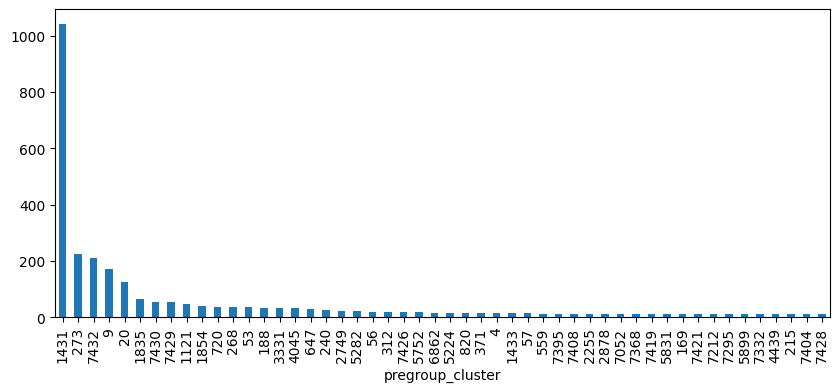

In [4]:
# kaggle
df_err_grouped_k = df_err_grouped[df_err_grouped["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
df_err_grouped_cluster_size_k = df_err_grouped_k.groupby("pregroup_cluster").size().sort_values(ascending=False)
print(len(df_err_grouped_cluster_size_k))
df_err_grouped_cluster_size_k.iloc[:50].plot(kind="bar", figsize=(10,4))

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The knee point is at number: 114


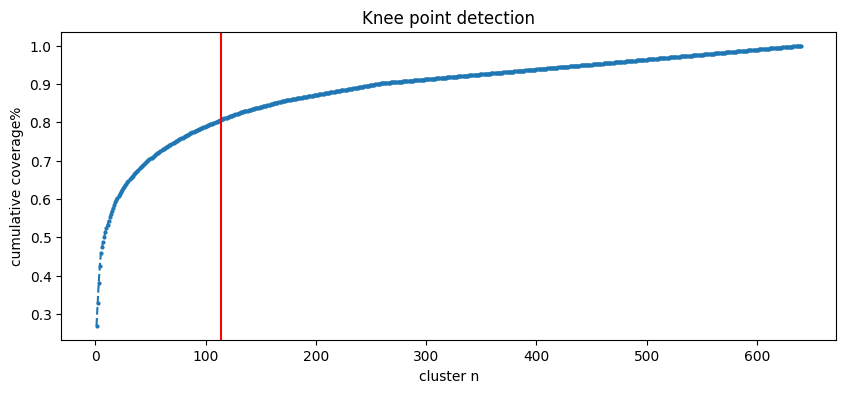

In [ ]:
import utils.cluster_util as cluster_util

cumsum_percentage_k = df_err_grouped_cluster_size_k.cumsum()/df_err_grouped_k.eid.nunique()
cluster_util.elbow_finder(cumsum_percentage_k, title = "Knee point - Kaggle")

In [5]:
# print(cumsum_percentage_k.searchsorted(0.8)) # num of clusters needed for cover certain percent of errors

cutoff_cluster_size_k = 10
n_clusters_k = sum(df_err_grouped_cluster_size_k>=cutoff_cluster_size_k)
print(n_clusters_k) # num of clusters needed for cluster size over ceratin number
print(sum(df_err_grouped_cluster_size_k[df_err_grouped_cluster_size_k>=cutoff_cluster_size_k])/df_err_grouped_k.eid.nunique()) # percentage

50
0.7058064516129032


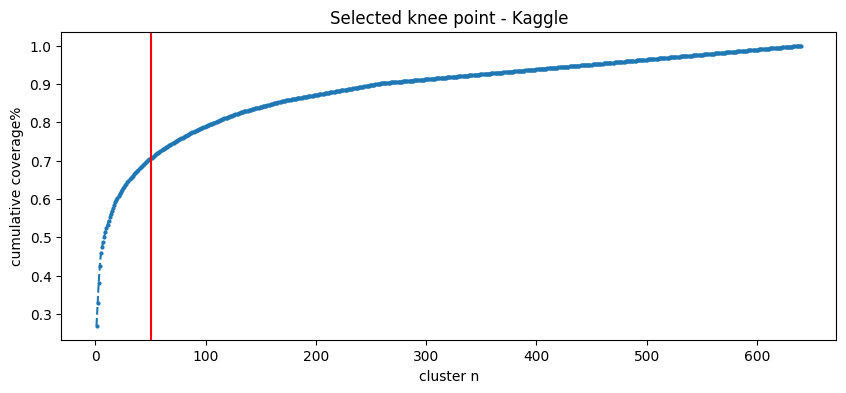

In [10]:
cluster_util.plot_elbow(cumsum_percentage_k, n_clusters_k, title="Selected knee point - Kaggle")

In [14]:
df_err_grouped_k.eid.nunique()

3875

In [37]:
top_clusters_k = df_err_grouped_cluster_size_k[df_err_grouped_cluster_size_k>=cutoff_cluster_size_k]
remaining_clusters_k = df_err_grouped_cluster_size_k[df_err_grouped_cluster_size_k<cutoff_cluster_size_k]
df_err_grouped_k["cluster_id"] = df_err_grouped_k.pregroup_cluster
df_err_grouped_k.loc[df_err_grouped_k.pregroup_cluster.isin(remaining_clusters_k.index), "cluster_id"]=-100

In [42]:
assert(df_err_grouped_k.cluster_id.nunique()==len(top_clusters_k)+1)

In [ ]:
df_err_grouped_k.to_excel(config.path_default.joinpath("clusters_Kaggle.xlsx"), index=False, engine='xlsxwriter')

7222


<Axes: xlabel='pregroup_cluster'>

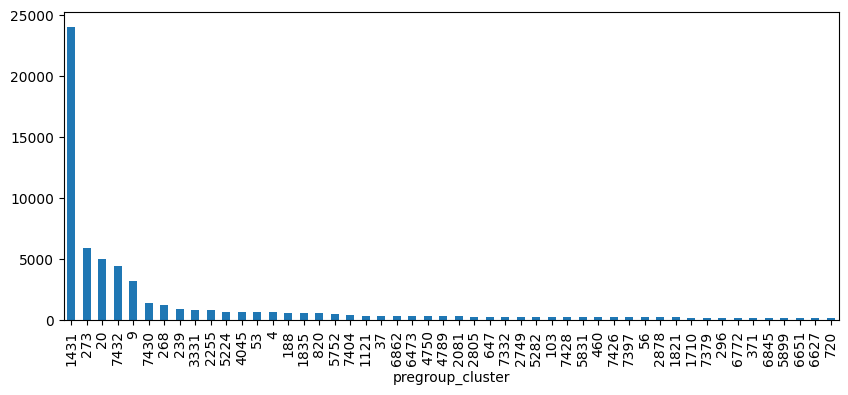

In [6]:
# github
df_err_grouped_g = df_err_grouped[df_err_grouped["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_err_grouped_cluster_size_g = df_err_grouped_g.groupby("pregroup_cluster").size().sort_values(ascending=False)
print(len(df_err_grouped_cluster_size_g))
df_err_grouped_cluster_size_g.iloc[:50].plot(kind="bar", figsize=(10,4))

The knee point is at number: 634


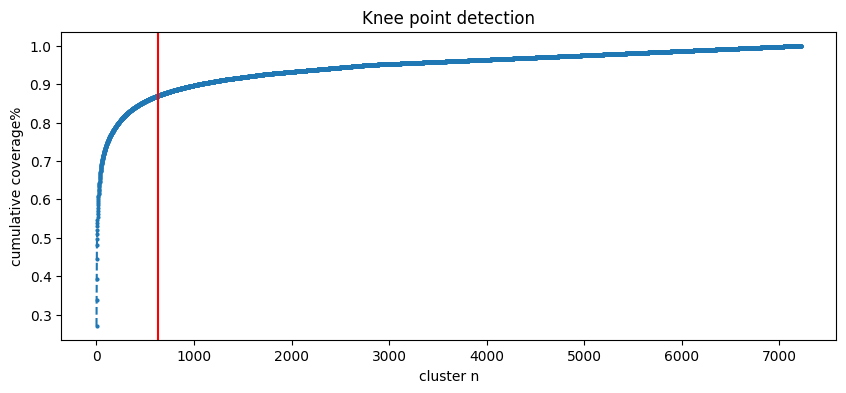

In [34]:
cumsum_percentage_g = df_err_grouped_cluster_size_g.cumsum()/df_err_grouped_g.eid.nunique()
cluster_util.elbow_finder(cumsum_percentage_g, title = "Knee point - GitHub")

In [7]:
# print(cumsum_percentage_g.searchsorted(0.85)) # num of clusters needed for cover certain percent of errors
cutoff_cluster_size_g = 100
n_clusters_g = sum(df_err_grouped_cluster_size_g>=cutoff_cluster_size_g)
print(n_clusters_g) # num of clusters needed for cluster size over ceratin number
print(sum(df_err_grouped_cluster_size_g[df_err_grouped_cluster_size_g>=cutoff_cluster_size_g])/df_err_grouped_g.eid.nunique()) # percentage

65
0.708572524163443


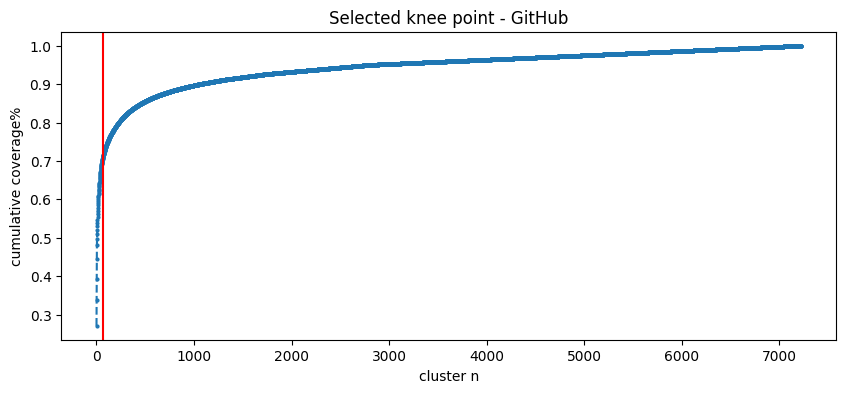

In [36]:
cluster_util.plot_elbow(cumsum_percentage_g, n_clusters_g, title="Selected knee point - GitHub")

In [45]:
len(df_err_grouped_g)

88667

In [44]:
top_clusters_g = df_err_grouped_cluster_size_g[df_err_grouped_cluster_size_g>=cutoff_cluster_size_g]
remaining_clusters_g = df_err_grouped_cluster_size_g[df_err_grouped_cluster_size_g<cutoff_cluster_size_g]
df_err_grouped_g["cluster_id"] = df_err_grouped_g.pregroup_cluster
df_err_grouped_g.loc[df_err_grouped_g.pregroup_cluster.isin(remaining_clusters_g.index), "cluster_id"]=-200

In [46]:
assert(df_err_grouped_g.cluster_id.nunique()==len(top_clusters_g)+1)

In [ ]:
df_err_grouped_g.to_excel(config.path_default.joinpath("clusters_GitHub.xlsx"), index=False, engine='xlsxwriter')

In [37]:
# # take union
# selected_clusters = df_err_grouped_cluster_size_g[df_err_grouped_cluster_size_g>=cutoff_cluster_size_g].index.union(
#     df_err_grouped_cluster_size_k[df_err_grouped_cluster_size_k>=cutoff_cluster_size_k].index)
# df_err_grouped_selected = df_err_grouped[df_err_grouped.pregroup_cluster.isin(selected_clusters)]

In [38]:
# # arrange based on selected clusters, sort
# selected_clusters_sorted = df_err_grouped_selected.groupby('pregroup_cluster').size().sort_values(ascending=False)
# sum(selected_clusters_sorted)/df_err_grouped.eid.nunique()

0.7137623997752371

In [39]:
# (selected_clusters_sorted.size)

79

In [ ]:
# selected_clusters = selected_clusters_sorted.to_frame().reset_index().rename(columns = {0:'cluster_size'})
# selected_clusters.to_excel(config.path_default.joinpath("df_err_processed_pregroup_cluster_sizes.xlsx"), index=False, engine='xlsxwriter')

### Initial sampling for manual evaluation

In [27]:
# select min(15,cluster_size) samples from kaggle and github max(30) per cluster for manual analysis

df_err_grouped_selected = None
sample_size = 15 # per source
for sc_id, cluster_size in selected_clusters_sorted.items():
    tmp_g = df_err_grouped[(df_err_grouped.pregroup_cluster == sc_id)&(df_err_grouped.nb_source == config.NB_SOURCE["github"])]
    tmp_k = df_err_grouped[(df_err_grouped.pregroup_cluster == sc_id)&(df_err_grouped.nb_source == config.NB_SOURCE["kaggle"])]
    sample_g = tmp_g.sample(n=min(sample_size, len(tmp_g)), random_state=7)
    sample_k = tmp_k.sample(n=min(sample_size, len(tmp_k)), random_state=7)
    sample_all = pd.concat([sample_g, sample_k], ignore_index=True)
    if df_err_grouped_selected is None:
        df_err_grouped_selected = sample_all
    else:
        df_err_grouped_selected = pd.concat([df_err_grouped_selected, sample_all], ignore_index=True)

In [28]:
print(df_err_grouped_selected.eid.nunique())
print(sum(selected_clusters_sorted>=30)*30 + sum(selected_clusters_sorted[selected_clusters_sorted<30])) # should be less than this

1884
2257


In [ ]:
df_err_grouped_selected.to_excel(config.path_default.joinpath("clusters_sampled_init.xlsx"), index=False, engine='xlsxwriter')